In [1]:
import colorsys
import imghdr
import random
import time
import cv2
from PIL import Image, ImageDraw, ImageFont
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body\

%matplotlib inline

Using TensorFlow backend.


In [2]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names


def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

In [3]:
def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [4]:
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes


def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    print (type(image),image.size)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data


In [5]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    font = ImageFont.truetype(font='Course_4/font/FiraMono-Medium.otf',
                              size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    print(image.size)
    thickness = (image.size[0] + image.size[1]) // 300

    tem1=[]
    tem2=[]
    tem3=[]
    for i in range(len(out_classes)):
        if out_classes[i] in [0,2,3,5,7,8]:
            tem1.append(out_scores[i])
            tem2.append(out_boxes[i])
            tem3.append(out_classes[i])
    out_scores=tem1
    out_boxes=tem2
    out_classes=tem3


    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        # print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [6]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=.4):
    """Filters YOLO boxes by thresholding on object and class confidence.

    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box

    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """

    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence * box_class_probs
    ### END CODE HERE ###

    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores, -1)
    box_class_scores = K.max(box_scores, -1)
    # print('box_class_scores shape:'+str(box_class_scores.shape))
    # print(box_class_scores[0,0,:].eval())
    ### END CODE HERE ###

    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = box_class_scores > threshold  #19 19 5 [[[true,false,true,true,false]]]
    # print(filtering_mask[0,0,:].eval())
    # print('filtering_mask shape:'+str(filtering_mask.shape))
    ### END CODE HERE ###

    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)   #  则  tf.boolean_mask(a,b) 将使a (m维)矩阵仅保留与b中“True”元素同下标的部分，并将结果展开到m-1维。
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE ###

    return scores, boxes, classes


In [7]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2

    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 5 lines)
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (yi2 - yi1) * (xi2 - xi1)
    ### END CODE HERE ###

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area
    ### END CODE HERE ###

    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area / union_area
    ### END CODE HERE ###

    return iou


def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes

    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box

    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """

    max_boxes_tensor = K.variable(max_boxes, dtype='int32')  # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))  # initialize variable max_boxes_tensor

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    ### END CODE HERE ###

    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    ### END CODE HERE ###

    return scores, boxes, classes


In [8]:
def yolo_eval(yolo_outputs, image_shape=(720., 1280.), max_boxes=20, score_threshold=.4, iou_threshold=.4):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.

    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """

    ### START CODE HERE ###

    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)

    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    ### END CODE HERE ###

    return scores, boxes, classes

In [9]:
def predict(sess, in_file,out_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.

    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.

    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes

    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes.
    """

    # Preprocess your image
    image, image_data = preprocess_image(in_file, model_image_size=(608, 608))

    # print(type(image))
    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],
                                                  feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(out_file, quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(out_file)
    imshow(output_image)

    return out_scores, out_boxes, out_classes


def predict2(sess,image,image_data):
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],
                                                  feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes '.format(len(out_boxes)))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    # image.save(image_file, quality=90)
    # Display the results in the notebook
    # output_image = scipy.misc.imread(image_file)
    # imshow(output_image)

    return out_scores, out_boxes, out_classes




In [10]:
sess = K.get_session()  #创建sess
class_names = read_classes("Course_4/model_data/coco_classes.txt")  #所需classes
print(class_names)
anchors = read_anchors("Course_4/model_data/yolo_anchors.txt")  #anchors参数
image_shape = (333., 500.)   #输入图片大小 (800., 1200.) 视频每帧大小1080
max_boxes=20 #最多发现车辆数
yolo_model = load_model("Course_4/model_data/yolo.h5")  #载入model
# yolo_model.summary()  #卷积神经网络具体过程
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape,max_boxes)
# out_scores, out_boxes, out_classes = predict(sess, "timg3.jpg")


# def testpicture():
#     start = time.time()
#     for i in range(1,121):
#         predict2(sess,str(i).zfill(4)+".jpg")
#     print (time.time()-start)
# testpicture()

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


/home/wang/.local/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<class 'PIL.JpegImagePlugin.JpegImageFile'> (500, 333)
Found 5 boxes for <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x7FD8157B3CC0>
(500, 333)
0.9145302772521973


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


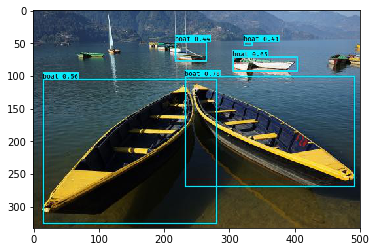

In [14]:
input = "Course_4/images/1116.jpg"
output = "Course_4/out/1116.jpg"
start = time.time()
predict(sess,input,output)
end = time.time()
print(end-start)